In [2]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import itertools
import datetime
#from datetime import datetime
from datetime import timedelta
import argparse
from sklearn.linear_model import LinearRegression
import sys
import math

In [ ]:
# Default mode should be logistic growth, manual entry, last 14 days, deterministic, 100 replications

# All inputs in bed demand sheet (highlighted in red or yellow)
# Red for covid, yellow for non covid
# Some are dropdown (planning period, trend, etc)
# Some trend choices require extra inputs!
# They enter % admit, recent # suspected cases, etc
# Determnistic or random (random done w/ simulation - monte carlo?)
# med surg is non-ICU patients
# Hospital must input their actual capacities (currently used, and what is left)
# Exponential and logistic trend has more inputs on the right (b/c it requires more historical information)
# Include historical information, then allow the to input how many of those past days to fit on
# No limit to amount of data put in column AV, but we control how much is considered

# yes, generate simulated data (but w/ same logic)

In [3]:
# get hospital admissions input from last 2 weeks from csv
hospital_admissions = pd.read_csv("hospital_info.csv")

hospital_admissions

,date,covid,non_covid
0,2022-11-19,39,8.0
1,2022-11-20,42,10.0
2,2022-11-21,42,12.0
3,2022-11-22,44,NaN
4,2022-11-23,55,NaN
5,2022-11-24,57,NaN
6,2022-11-25,57,NaN
7,2022-11-26,58,NaN
8,2022-11-27,66,NaN
9,2022-11-28,57,NaN


In [15]:
# excel LINEST function recreate
np.polyfit(range(0,15),hospital_admissions.covid,2)

# that's y = 2.4357x + 40.55

x = 
#ans = 2.4357*2 + 40.55
ans = -0.09453782*x**2 + 3.7592437*x + 37.682
print(ans)

41.34670588


In [46]:
p = np.polyfit(range(0,15), np.log(hospital_admissions.covid), 1)
p

num_days = 21

a = np.exp(p[1])
b = p[0]
x_fitted = np.linspace(15, 15+21, num_days)
y_fitted = a * np.exp(b * x_fitted)

y_fitted

array([ 80.47153514,  84.30295528,  88.31679744,  92.52174712,
        96.92690336, 101.54179841, 106.37641839, 111.44122485,
       116.74717748, 122.30575774, 128.12899377, 134.2294864 ,
       140.62043639, 147.31567305, 154.32968409, 161.67764705,
       169.37546208, 177.43978638, 185.88807023, 194.73859475,
       204.01051149])

In [5]:
# patient census input
patient_census = pd.DataFrame(columns=["covid","non_covid"], index=["MedSurg", "ICU", "ICU_vent"])
patient_census.covid = [70,8.25,3.75]
patient_census.non_covid = [130,4,9]

patient_census

,covid,non_covid
MedSurg,70.00,130
ICU,8.25,4
ICU_vent,3.75,9


In [6]:
# covid LOS and location data
covid_LOS_location = pd.DataFrame(index=["LOS","percent"], columns=["MedSurg", "ICU", "ICU_vent", "ICU_to_MedSurg", "MedSurg_to_ICU"])

# enter data
covid_LOS_location.MedSurg = [6,.65]
covid_LOS_location.ICU = [2, 0.03]
covid_LOS_location.ICU_vent = [12, 0.32]
covid_LOS_location.ICU_to_MedSurg = [6, 1]
covid_LOS_location.MedSurg_to_ICU = [2, 0]
                        

# same for non-covid
non_covid_LOS_location = pd.DataFrame(index=["LOS","percent"], columns=["MedSurg", "ICU", "ICU_vent", "ICU_to_MedSurg", "MedSurg_to_ICU"])

# enter data
non_covid_LOS_location.MedSurg = [4,.91]
non_covid_LOS_location.ICU = [2, 0.03]
non_covid_LOS_location.ICU_vent = [4, 0.06]
non_covid_LOS_location.ICU_to_MedSurg = [4, .6]
non_covid_LOS_location.MedSurg_to_ICU = [1, .4]


non_covid_LOS_location.head()

,MedSurg,ICU,ICU_vent,ICU_to_MedSurg,MedSurg_to_ICU
LOS,4.00,2.00,4.00,4.0,1.0
percent,0.91,0.03,0.06,0.6,0.4


In [7]:
capacity = pd.DataFrame(columns=["MedSurg","ICU","ventilators"],index=["covid","non_covid","current","additional"])

capacity.MedSurg = [121,170, np.nan, np.nan]
capacity.ICU = [67, 28, np.nan, np.nan]
capacity.ventilators = [np.nan, np.nan, 80, 0]

capacity

,MedSurg,ICU,ventilators
covid,121.0,67.0,NaN
non_covid,170.0,28.0,NaN
current,NaN,NaN,80.0
additional,NaN,NaN,0.0


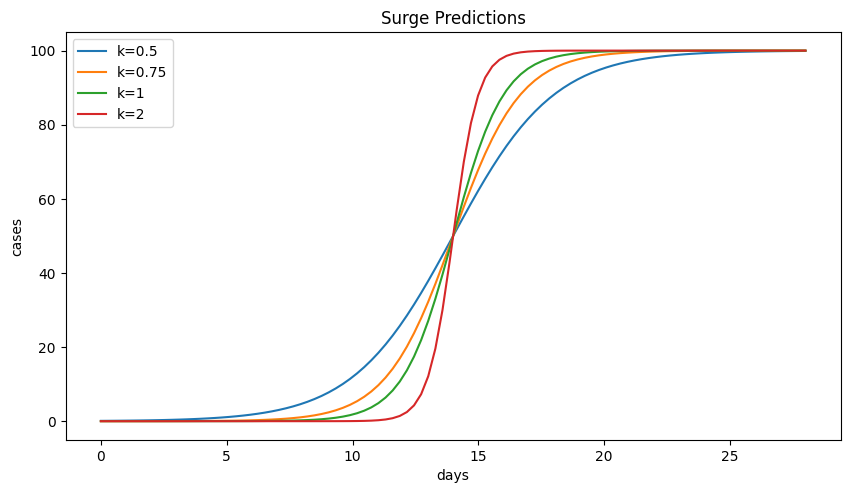

In [8]:
# logistic growth testing (Ask about paper for math)

t = np.linspace(0, 14*2, 100)

fig = plt.figure(figsize=(10, 18))

ax = fig.add_subplot(3, 1, 1)
t0, L = 14, 100
for k in [0.5, 0.75, 1, 2]:
    D = L / (1. + np.exp(-k * (t - t0)))
    _ = plt.plot(t, D, label=f'k={k}')
_ = ax.legend()
_ = ax.set_xlabel('days')
_ = ax.set_ylabel('cases')
_ = ax.set_title('Surge Predictions')



In [ ]:
# linearize logistic growth equation
# growth rate based on last 14 days
# log normal cumulative dstribution S curve fit data the best
# lin reg
# random as well as deterministic

In [12]:
def file_argparse(args):
    """This function sets up argparse so that the
    script can accept the required inputs"""
    parser = argparse.ArgumentParser(description="input deterministic")
    parser.add_argument('-i1', '--determ1', dest='mode1',
                        help="input doubling time in days",
                        default=10)
    return parser.parse_args(args)


In [1]:
type(hospital_admissions)

NameError: name 'hospital_admissions' is not defined

In [8]:
class Deterministic:
    """Class for predicting admission rates and future counts in deterministic mode, but also with manual capabilities"""
    
    def __init__(self, planning_period, my_data, my_rate_covid=None, my_rate_non_covid=None):
        self.planning_period = planning_period
        self.my_data = my_data
        
        # these ones are optional, only include if you want a manual version! else, rates will be calculated based on input data
        self.my_rate_covid = my_rate_covid
        self.my_rate_non_covid = my_rate_non_covid
        
        
    def find_rate(self, covid_status):
        # skips calculations if inputs were manually entered
        if covid_status == "covid" and self.my_rate_covid is not None:
            return self.my_rate_covid*100
        elif covid_status == "non_covid" and self.my_rate_non_covid is not None:
            return self.my_rate_non_covid*100
        
        # else, let's calculate it
        # covid status is either "covid" or "non_covid"
        if covid_status not in ["covid","non_covid"]:
            pass
            sys.exit("that won't work")
        last = self.my_data.loc[self.planning_period - 1, covid_status]
        first = self.my_data.loc[0, covid_status]
        
        my_rate = (last - first)/np.abs(first)/self.planning_period*100
        return my_rate
        
        
    def doubling_time(self, covid_status):
        rate = self.find_rate(covid_status)
        doub = np.log(2)/np.log(1 + rate/100)
        return doub
    # backwards version (add this!)
        
    def predictions(self):
        # get rate
        my_rate_covid = self.find_rate("covid")/100
        my_rate_non_covid = self.find_rate("non_covid")/100
        
        # initialize pd of predictions
        my_predictions = pd.DataFrame(columns=["date","covid","non_covid"], index=range(0,self.planning_period))
        
        # add dates to predictions df
        last_date = self.my_data.loc[self.planning_period - 1,"date"]
        # change format to datetime.date (is curr. stored as string)
        last_date = datetime.datetime.strptime(last_date, '%Y-%m-%d')
        last_date = datetime.datetime.date(last_date)
        
        # initialize list for next days
        all_days = []
 
        # loop through range of dates we're making predictions for
        for day in range(1, self.planning_period + 1):
            date = (last_date + datetime.timedelta(days = day)).isoformat()
            all_days.append(date)
            
        # add new dates to df
        my_predictions.date = all_days

        # initialize list
        list_predict_covid = []
        list_predict_non_covid = []
        
        # initialize last data point
        last_dp_covid = self.my_data.loc[self.planning_period-1,"covid"]
        last_dp_non_covid = self.my_data.loc[self.planning_period-1,"non_covid"]
        
        for i in range(0, self.planning_period):
            # calc ahead w/ exp growth rate
            new_i_covid = last_dp_covid*(1+(my_rate_covid))**1
            new_i_non_covid = last_dp_non_covid*(1+(my_rate_non_covid))**1
            # add to list
            list_predict_covid.append(new_i_covid)
            list_predict_non_covid.append(new_i_non_covid)
            # change last data point to this one
            last_dp_covid = new_i_covid
            last_dp_non_covid = new_i_non_covid
            
        # rounding = true vs false
        
        # consider prob. intervals
        # simulations (monte carlo), gen. samples from distributions
            
        
        # add predictions to df
        my_predictions.covid = list_predict_covid
        my_predictions.non_covid = list_predict_non_covid
            
        return my_predictions
        
    def projection(self):
        # to predict case counts, we will use existing input data (in pd df)
        if not isinstance(self.my_data, pd.core.frame.DataFrame):
            sys.exit("nope")
        else:
            print("yep")
            


In [15]:
x = Deterministic(14, hospital_admissions).find_rate("covid")
print(x)

y = Deterministic(12, hospital_admissions).doubling_time("covid")
print(y)


len(hospital_admissions)
hospital_admissions.loc[13,"covid"]
hospital_admissions.loc[0,"covid"]

6.227106227106227
10.480030999673966


39

# Testing Deterministic Mode

In [19]:
print("ans: ",10*(1+(x/100))**14)

my_det = Deterministic(15, hospital_admissions, my_rate_covid=0.0693, my_rate_non_covid=0.0693)

print(f"covid rate: {round(my_det.find_rate('covid'), 3)}%")
print(f"non-covid rate: {round(my_det.find_rate('non_covid'), 3)}%")
det_graph = my_det.predictions()
det_graph

ans:  23.296727082245944
covid rate: 6.93%
non-covid rate: 6.93%


,date,covid,non_covid
0,2022-12-04,73.781700,NaN
1,2022-12-05,78.894772,NaN
2,2022-12-06,84.362179,NaN
3,2022-12-07,90.208479,NaN
4,2022-12-08,96.459926,NaN
5,2022-12-09,103.144599,NaN
6,2022-12-10,110.292520,NaN
7,2022-12-11,117.935791,NaN
8,2022-12-12,126.108742,NaN
9,2022-12-13,134.848077,NaN


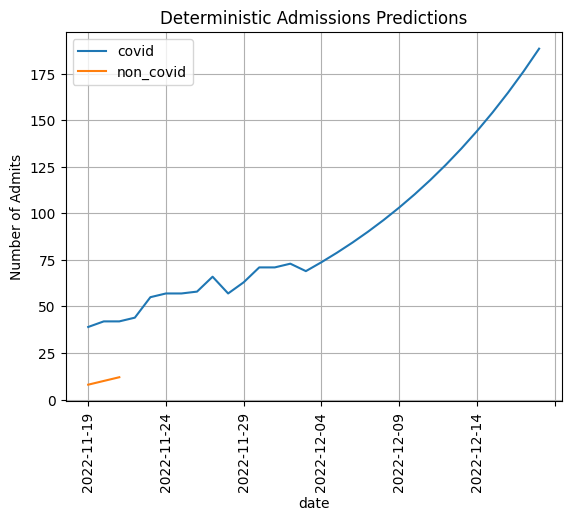

In [18]:
# graphing
det_graph_all = hospital_admissions.append(det_graph)
det_graph_all.plot.line(x="date",y=["covid","non_covid"])
plt.title("Deterministic Admissions Predictions")
plt.xticks(rotation=90)
plt.ylabel("Number of Admits")
plt.grid()
plt.show()

# Testing Deterministic with Rate Input Mode

In [14]:
# let's test out a manual version
# same data, except I choose the rate of increase rather than calculating it based on previous data
# previous data is just used in predictions, not for finding rate or doubling time
# I randomly chose rates just to test this out

# call it (important to specify which rate is covid vs non-covid (default is covid first, non-covid second)
my_manual = Deterministic(14, hospital_admissions, my_rate_covid=0.093, my_rate_non_covid=0.0384)

print(f"covid rate: {round(my_manual.find_rate('covid'), 3)}%")
print(f"non-covid rate: {round(my_manual.find_rate('non_covid'), 3)}%")
manual_df = my_manual.predictions()
manual_df

covid rate: 9.3%
non-covid rate: 3.84%


,date,covid,non_covid
0,2020-04-26,12.023000,18.691200
1,2020-04-27,13.141139,19.408942
2,2020-04-28,14.363265,20.154245
3,2020-04-29,15.699049,20.928168
4,2020-04-30,17.159060,21.731810
5,2020-05-01,18.754853,22.566312
6,2020-05-02,20.499054,23.432858
7,2020-05-03,22.405466,24.332680
8,2020-05-04,24.489174,25.267055
9,2020-05-05,26.766668,26.237310


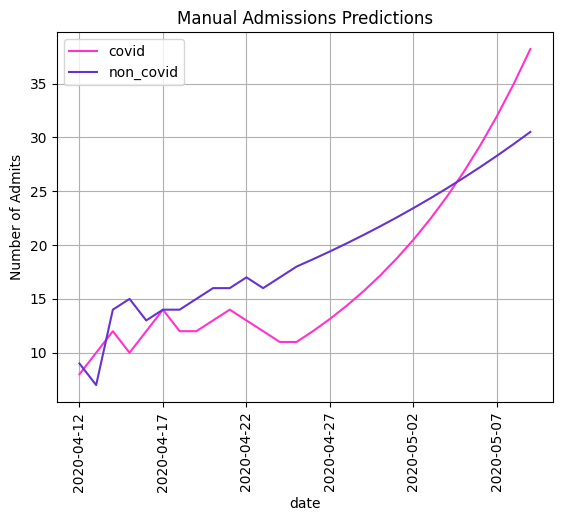

In [15]:
# graphing manual
# graphing
manual_df_all = hospital_admissions.append(manual_df)
manual_df_all.plot.line(x="date",y=["covid","non_covid"], color=["#FF33CC","#6633CC"])
plt.title("Manual Admissions Predictions")
plt.xticks(rotation=90)
plt.ylabel("Number of Admits")
plt.grid()
plt.show()

In [20]:
covid_percents = covid_LOS_location.loc["percent",["MedSurg", "ICU", "ICU_vent"]]

non_covid_percents = non_covid_LOS_location.loc["percent",["MedSurg", "ICU", "ICU_vent"]]

det_graph_section = det_graph
det_graph_section["MedSurg_covid"] = ''
det_graph_section["ICU_covid"] = ''
det_graph_section["ICU_vent_covid"] = ''
det_graph_section["MedSurg_non_covid"] = ''
det_graph_section["ICU_non_covid"] = ''
det_graph_section["ICU_vent_non_covid"] = ''

det_graph_section

,date,covid,non_covid,MedSurg_covid,ICU_covid,ICU_vent_covid,MedSurg_non_covid,ICU_non_covid,ICU_vent_non_covid
0,2022-12-04,73.781700,NaN,,,,,,
1,2022-12-05,78.894772,NaN,,,,,,
2,2022-12-06,84.362179,NaN,,,,,,
3,2022-12-07,90.208479,NaN,,,,,,
4,2022-12-08,96.459926,NaN,,,,,,
5,2022-12-09,103.144599,NaN,,,,,,
6,2022-12-10,110.292520,NaN,,,,,,
7,2022-12-11,117.935791,NaN,,,,,,
8,2022-12-12,126.108742,NaN,,,,,,
9,2022-12-13,134.848077,NaN,,,,,,


In [21]:
det_graph_section.MedSurg_covid =  det_graph_section.covid * covid_percents[0]
det_graph_section.ICU_covid =  det_graph_section.covid * covid_percents[1]
det_graph_section.ICU_vent_covid =  det_graph_section.covid * covid_percents[2]
det_graph_section.MedSurg_non_covid =  det_graph_section.non_covid * non_covid_percents[0]
det_graph_section.ICU_non_covid =  det_graph_section.non_covid * non_covid_percents[1]
det_graph_section.ICU_vent_non_covid =  det_graph_section.non_covid * non_covid_percents[2]


det_graph_section

,date,covid,non_covid,MedSurg_covid,ICU_covid,ICU_vent_covid,MedSurg_non_covid,ICU_non_covid,ICU_vent_non_covid
0,2022-12-04,73.781700,NaN,47.958105,2.213451,23.610144,NaN,NaN,NaN
1,2022-12-05,78.894772,NaN,51.281602,2.366843,25.246327,NaN,NaN,NaN
2,2022-12-06,84.362179,NaN,54.835417,2.530865,26.995897,NaN,NaN,NaN
3,2022-12-07,90.208479,NaN,58.635511,2.706254,28.866713,NaN,NaN,NaN
4,2022-12-08,96.459926,NaN,62.698952,2.893798,30.867176,NaN,NaN,NaN
5,2022-12-09,103.144599,NaN,67.043989,3.094338,33.006272,NaN,NaN,NaN
6,2022-12-10,110.292520,NaN,71.690138,3.308776,35.293606,NaN,NaN,NaN
7,2022-12-11,117.935791,NaN,76.658264,3.538074,37.739453,NaN,NaN,NaN
8,2022-12-12,126.108742,NaN,81.970682,3.783262,40.354797,NaN,NaN,NaN
9,2022-12-13,134.848077,NaN,87.651250,4.045442,43.151385,NaN,NaN,NaN


In [18]:
det_graph_section_round = det_graph_section.round(decimals = 0)

det_graph_section_round

,date,covid,non_covid,MedSurg_covid,ICU_covid,ICU_vent_covid,MedSurg_non_covid,ICU_non_covid,ICU_vent_non_covid
0,2020-04-26,11.0,19.0,7.0,0.0,4.0,18.0,1.0,1.0
1,2020-04-27,12.0,21.0,8.0,0.0,4.0,19.0,1.0,1.0
2,2020-04-28,12.0,22.0,8.0,0.0,4.0,20.0,1.0,1.0
3,2020-04-29,12.0,24.0,8.0,0.0,4.0,22.0,1.0,1.0
4,2020-04-30,13.0,25.0,8.0,0.0,4.0,23.0,1.0,2.0
5,2020-05-01,13.0,27.0,8.0,0.0,4.0,25.0,1.0,2.0
6,2020-05-02,13.0,29.0,9.0,0.0,4.0,27.0,1.0,2.0
7,2020-05-03,14.0,31.0,9.0,0.0,4.0,28.0,1.0,2.0
8,2020-05-04,14.0,33.0,9.0,0.0,4.0,30.0,1.0,2.0
9,2020-05-05,14.0,36.0,9.0,0.0,5.0,33.0,1.0,2.0


In [19]:
# step down information
# ICU (both) to medsurg, ICU vent to no vent, ICU no vent to vent, Medsurg to ICU (both), new incoming, and discharge/die

movement = pd.DataFrame(columns=["intake_MedSurg", "intake_ICU", "intake_ICU_vent","discharge", 
                                           "ICU_to_MedSurg", "Medsurg_to_ICU", "ICU_vent_to_no_vent", "ICU_no_vent_to_vent"], index=["LOS", "percent"])



movement.intake_MedSurg = [4, 0.91]
movement.intake_ICU = [2, 0.03]
movement.intake_ICU_vent = [4, 0.06]
movement.ICU_to_MedSurg = [4, 0.6]
movement.Medsurg_to_ICU = [1, 0.4]

movement

,intake_MedSurg,intake_ICU,intake_ICU_vent,discharge,ICU_to_MedSurg,Medsurg_to_ICU,ICU_vent_to_no_vent,ICU_no_vent_to_vent
LOS,4.00,2.00,4.00,NaN,4.0,1.0,NaN,NaN
percent,0.91,0.03,0.06,NaN,0.6,0.4,NaN,NaN


In [20]:
# logistic regression
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


In [44]:
# make numpy arrays
covid_array = hospital_admissions['covid'].to_numpy()
non_covid_array = hospital_admissions['non_covid'].to_numpy()
dates_array = hospital_admissions['date'].to_numpy()

# get x for predictions (just dates)
x = np.arange(len(dates_array)).reshape(-1, 1)

def sigmoid1(z):
    return 1 / (1 + np.exp(-z))
# Creating sample Z points
#
z = np.arange(-5, 5, 0.48)

sigmoid1(z)

from scipy.optimize import curve_fit
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

# these can all be together
p0 = [max(covid_array), np.median(x),1,min(covid_array)]

# curve fitting done here
popt, pcov = curve_fit(sigmoid, range(0,14), hospital_admissions['covid'].to_list(),p0, method='dogbox')

# L is scales the output range from [0,1] to [0,output] - this is just the number of days!
# b adds bias to the output and changes its range from [0,L] to [b,L+b]
# k scales the input, which remains in (-inf,inf)#
# x0 is the point in the middle of the Sigmoid
# x is any x being fitted

popt

array([ 33.72313982,  -2.74885305,   0.69528441, -21.36023296])

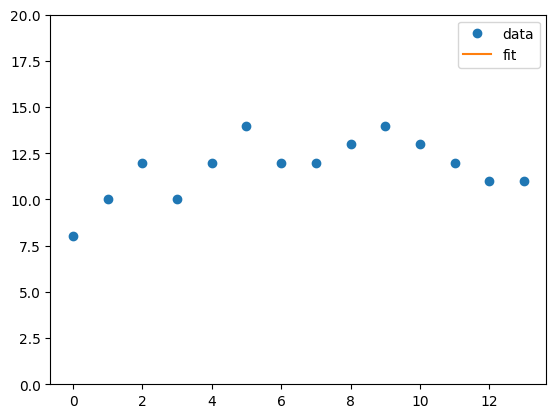

array([8.01794308])

In [53]:
x = np.linspace(0, 15, 1)
y = sigmoid(x, *popt)

plt.plot(range(0,14), hospital_admissions["covid"].to_list(), 'o', label='data')
plt.plot(x,y, label='fit')
plt.ylim(0, 20)
plt.legend(loc='best')

plt.show()

y

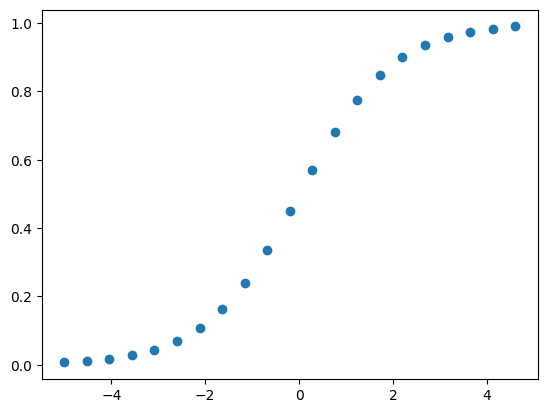

In [58]:
sigmoid1(z)

plt.plot(z, sigmoid1(z), 'o', label="Data")

In [43]:
# define new input values
x_new = range(0,24)
# unpack optima parameters for the objective function
a, b, c, d = optimal
# use optimal parameters to calculate new values
y_new = sigmoid(x_new, a, b, c, d)


#see new
y_new

array([ 8.01794308, 10.04545132, 11.16541938, 11.75461838, 12.05664391,
       12.2094038 , 12.28614411, 12.3245637 , 12.34376531, 12.3533538 ,
       12.35813986, 12.36052828, 12.36172007, 12.36231473, 12.36261143,
       12.36275946, 12.36283332, 12.36287017, 12.36288856, 12.36289773,
       12.36290231, 12.36290459, 12.36290573, 12.3629063 ])

In [39]:
# manual predictions (input by the user no curve fitting)
manual_cov = [5,6,8,10,12,16,20,25,32,35,38,40,40,40,40,39,38,37,36,35,35,34,33,32,30,28,26,25,24,23]

# dates
start_date = datetime.date(2022,5,1)
all_days = []
num_days = 30
 
for day in range(num_days):
    date = (start_date + datetime.timedelta(days = day)).isoformat()
    all_days.append(date)
    

manual_predictions = pd.DataFrame(columns=["date","covid_predictions","non_covid_predictions"])

manual_predictions.covid_predictions = manual_cov

manual_predictions.date = all_days


In [41]:
class Manual:
    """Class for manual predictions of hospital admissions and flow"""
    
    def __init__(self, my_data, covid_nums, non_covid_nums,dates):
        self.my_data = my_data
        self.covid_nums = covid_nums
        self.non_covid_nums = non_covid_nums
        self.dates = dates
        
    def predict_covid(self):
        # uses predictions from user instead of curve fitting
        # hence "manual"
        
        # get percents for admission
        ms_pct = self.covid_nums[0]
        icu_pct = self.covid_nums[1]
        icu_vent_pct = self.covid_nums[2]
        
        # get input predictions
        pre = self.my_data["covid_predictions"]
        
        # output patient admission by section
        post = pd.DataFrame(columns=["date","MedSurge","ICU", "ICU_vent"])
        
        # dates
        post.date = self.dates
        
        for i in range(0, len(pre)):
            
            ms = ms_pct*pre[i]
            icu = icu_pct*pre[i]
            icu_vent = icu_vent_pct*pre[i]
            
            # regular
            #post.loc[i,"MedSurge"] = ms
            #post.loc[i, "ICU"] = icu
            #post.loc[i, "ICU_vent"] = icu_vent
            
            # rounded version
            post.loc[i,"MedSurge"] = math.ceil(ms)
            post.loc[i, "ICU"] = math.ceil(icu)
            post.loc[i, "ICU_vent"] = math.ceil(icu_vent)
        
        return post
    
    
x = Manual(manual_predictions,covid_percents,non_covid_percents, all_days).predict_covid()

x
            
            
            
            
            
        

        
        

,date,MedSurge,ICU,ICU_vent
0,2022-05-01,4,1,2
1,2022-05-02,4,1,2
2,2022-05-03,6,1,3
3,2022-05-04,7,1,4
4,2022-05-05,8,1,4
5,2022-05-06,11,1,6
6,2022-05-07,13,1,7
7,2022-05-08,17,1,8
8,2022-05-09,21,1,11
9,2022-05-10,23,2,12
